Bibliotecas

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

Datasets

In [96]:
path_test = r'C:\Users\T-Gamer\Desktop\Python_Estudo\Curso_analise_de_dados\Store Sales\test.csv'
path_train = r'C:\Users\T-Gamer\Desktop\Python_Estudo\Curso_analise_de_dados\Store Sales\train.csv'
path_trans = r'C:\Users\T-Gamer\Desktop\Python_Estudo\Curso_analise_de_dados\Store Sales\transactions.csv'
path_stores = r'C:\Users\T-Gamer\Desktop\Python_Estudo\Curso_analise_de_dados\Store Sales\stores.csv'
path_oil = r'C:\Users\T-Gamer\Desktop\Python_Estudo\Curso_analise_de_dados\Store Sales\oil.csv'
path_holidays = r'C:\Users\T-Gamer\Desktop\Python_Estudo\Curso_analise_de_dados\Store Sales\holidays_events.csv'

test = pd.read_csv(path_test, parse_dates=['date'], infer_datetime_format=True)
train = pd.read_csv(path_train, parse_dates=['date'], infer_datetime_format=True)
trans = pd.read_csv(path_trans, parse_dates=['date'], infer_datetime_format=True)
stores = pd.read_csv(path_stores)
oil = pd.read_csv(path_oil, parse_dates=['date'], infer_datetime_format=True)
holidays = pd.read_csv(path_holidays, parse_dates=['date'], infer_datetime_format=True)

Média temporal de vendas

In [97]:
df = train.set_index('date').to_period('D')
df = df.set_index(['store_nbr', 'family'], append=True)
sale = df.groupby('date')
avg_sale = sale.mean()['sales']

df = avg_sale.to_frame()
df['days'] = np.arange(len(df.index))

X = df.drop('sales', axis=1)
y = df['sales']

In [98]:
modelo = LinearRegression()
modelo2 = XGBRegressor()
modelo.fit(X,y)
modelo2.fit(X,y)

mae1 = mean_absolute_error(y, modelo.predict(X))
mae2 = mean_absolute_error(y, modelo2.predict(X))

print(mae1, mae2)

71.85506115573342 33.1047008699542


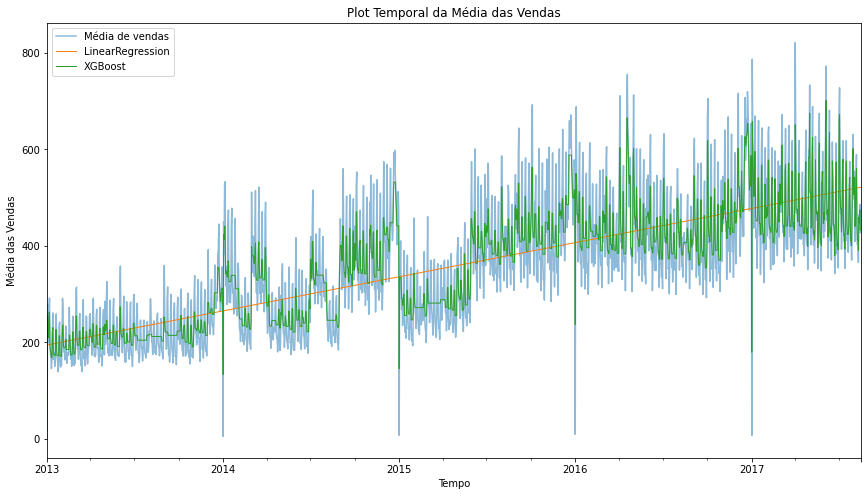

In [99]:
y_pred = pd.Series(modelo.predict(X), index=X.index)
y_pred2 = pd.Series(modelo2.predict(X), index=X.index)

plt.figure(figsize=(15,8))
ax = y.plot(alpha=0.5, label='Média de vendas')
ax = y_pred.plot(ax=ax, linewidth=1, label='LinearRegression')
ax = y_pred2.plot(ax=ax, linewidth=1, label='XGBoost')
ax.set_title('Média das Vendas')
ax.set(aspect='equal', ylabel='Média das Vendas', xlabel='Tempo', title='Plot Temporal da Média das Vendas')
_ = ax.legend()

Tendência

[None,
 Text(0, 0.5, 'Média das Vendas'),
 Text(0.5, 0, 'Tempo'),
 Text(0.5, 1.0, 'Plot Temporal da Média das Vendas')]

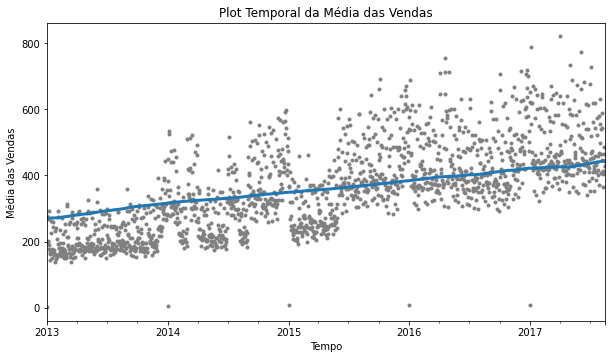

In [100]:
mov_avg =avg_sale.rolling(
    window=len(avg_sale.index),
    center=True,
    min_periods=len(avg_sale.index)//2
).mean()

plt.figure(figsize=(10,8))
ax = avg_sale.plot(style=".", color="0.5")
mov_avg.plot(ax=ax, linewidth=3)
ax.set(aspect='equal', ylabel='Média das Vendas', xlabel='Tempo', title='Plot Temporal da Média das Vendas')

Gerando time dummy com Deterministic Process (linear)

[None,
 Text(0, 0.5, 'Média das Vendas'),
 Text(0.5, 0, 'Tempo'),
 Text(0.5, 1.0, 'Plot Temporal da Média das Vendas')]

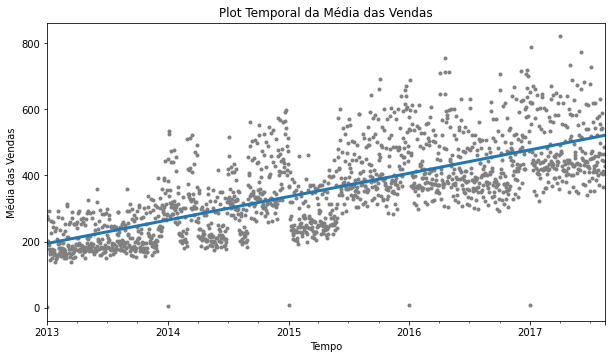

In [101]:
dp = DeterministicProcess(
    index=X.index,
    constant=True,
    order=1,
    drop=True)

X=dp.in_sample()

modelo = LinearRegression(fit_intercept=False)
modelo.fit(X,y)

y_prev = pd.Series(modelo.predict(X), index=X.index)

plt.figure(figsize=(10,7))
ax = avg_sale.plot(style='.', color="0.5", title="Tendência linear da média de vendas")
y_prev.plot(ax=ax, linewidth=3)
ax.set(aspect='equal', ylabel='Média das Vendas', xlabel='Tempo', title='Plot Temporal da Média das Vendas')

Forecasting linear de 150 dias na tendência

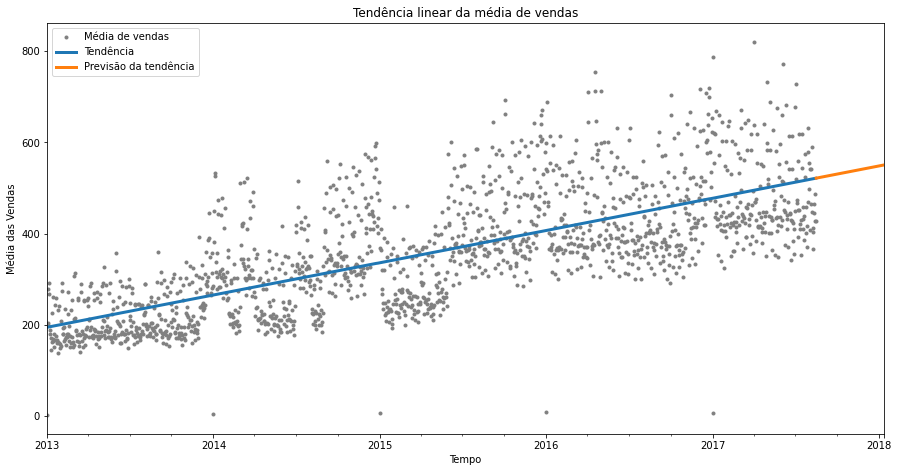

In [102]:
X = dp.out_of_sample(steps=150)
y_prev_2018_jan = pd.Series(modelo.predict(X), index=X.index)

plt.figure(figsize=(15,10))
ax = avg_sale.plot(style='.', color="0.5", title="Tendência linear da média de vendas", label='Média de vendas')
y_prev.plot(ax=ax, linewidth=3, label='Tendência')
y_prev_2018_jan.plot(ax=ax, linewidth=3, label='Previsão da tendência')
ax.set(aspect='equal', ylabel='Média das Vendas', xlabel='Tempo')
_ = ax.legend()

Lag Feature

Autocorrelação lag_1: 0.7651434264052153
Autocorrelação lag_2: 0.5627674997753974
Autocorrelação lag_3: 0.5311974205619657


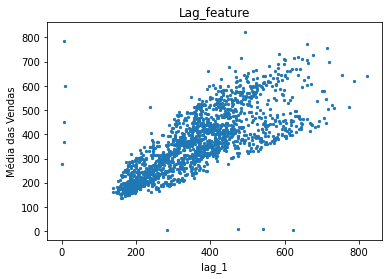

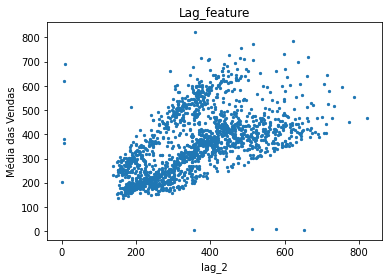

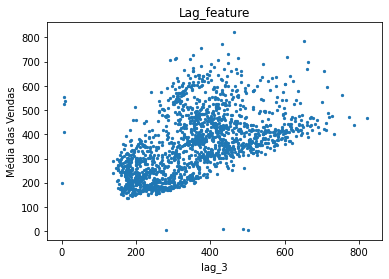

In [103]:
lag = pd.DataFrame({'avg':avg_sale, 'lag_1':avg_sale.shift(1), 'lag_2':avg_sale.shift(2), 'lag_3':avg_sale.shift(3)})
ac = sm.tsa.acf(avg_sale, nlags=3)

columns = ['lag_1', 'lag_2', 'lag_3']
autocorr = {'lag_1':ac[1], 'lag_2':ac[2], 'lag_3':ac[3]}

for i in columns:
    fig, ax = plt.subplots()
    ax.scatter(lag[i], lag['avg'], s=5)
    ax.set(ylabel='Média das Vendas', xlabel=i, title="Lag_feature")
    print(f'Autocorrelação {i}: {autocorr[i]}')

Reagrupando os datasets para aplicação do modelo

In [104]:
train_aux = pd.merge(train, holidays, on='date', how='left')
train = pd.merge(train_aux, oil, on='date', how='left')
test_aux = pd.merge(test, holidays, on='date', how='left')
test = pd.merge(test_aux, oil, on='date', how='left')

train['type'] = train['type'].replace(['Holiday', 'Event', 'Additional', 'Transfer', 'Work Day', 'Bridge'], 1)
test['type'] = test['type'].replace(['Holiday', 'Event', 'Additional', 'Transfer', 'Work Day', 'Bridge'], 1)

train['type'] = train['type'].fillna(0)
test['type'] = test['type'].fillna(0)


Pré-processamento

In [105]:
si = SimpleImputer(strategy='median')
si.fit(train[['dcoilwtico']])
si.fit(test[['dcoilwtico']])

train['dcoilwtico'] = si.transform(train[['dcoilwtico']])
test['dcoilwtico'] = si.transform(test[['dcoilwtico']])

le = LabelEncoder()
fam_labels = le.fit_transform(train['family'])
train['family'] = fam_labels


let = LabelEncoder()
famt_labels = let.fit_transform(test['family'])
test['family'] = famt_labels


In [106]:
train = train.drop(['locale', 'locale_name', 'description', 'transferred'], axis=1)
test = test.drop(['locale', 'locale_name', 'description', 'transferred'], axis=1)

train.head()

,id,date,store_nbr,family,sales,onpromotion,type,dcoilwtico
0,0,2013-01-01,1,0,0.0,0,1.0,47.25
1,1,2013-01-01,1,1,0.0,0,1.0,47.25
2,2,2013-01-01,1,2,0.0,0,1.0,47.25
3,3,2013-01-01,1,3,0.0,0,1.0,47.25
4,4,2013-01-01,1,4,0.0,0,1.0,47.25


In [107]:
X = train.drop('sales', axis=1)
y = train['sales']

X = X.drop('id', axis=1)
id = test['id']
test = test.drop('id', axis=1)

X = X.drop(['date'], axis = 1)
date = test['date']
test = test.drop(['date'], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       int32  
 2   onpromotion  int64  
 3   type         float64
 4   dcoilwtico   float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 128.2 MB


Optimizando o dataset

In [108]:
X['family'] = X['family'].astype('int8')
X['store_nbr'] = X['store_nbr'].astype('int8')
X['onpromotion'] = X['onpromotion'].astype('int16')
X['type'] = X['type'].astype('float16')
X['dcoilwtico'] = X['dcoilwtico'].astype('float16')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int8   
 1   family       int8   
 2   onpromotion  int16  
 3   type         float16
 4   dcoilwtico   float16
dtypes: float16(2), int16(1), int8(2)
memory usage: 46.6 MB


Validando e optimizando o modelo com learning rate

In [110]:
X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.75)

mae = []
mae_treino = []
lr = np.linspace(0.095, 0.12, 5)

for k in lr:
    modelo = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=k, n_jobs=12)
    modelo.fit(X_treino, y_treino, 
            early_stopping_rounds=5, 
            eval_set=[(X_valid, y_valid)], 
            verbose=False)
    w = mean_absolute_error(y_valid, modelo.predict(X_valid))
    w_treino = mean_absolute_error(y_treino, modelo.predict(X_treino))
    print(f'(lr={k}) erro_valid: {w}, erro_train : {w_treino}')
  

(lr=0.095) erro_valid: 126.05622973484981, erro_train : 122.58150775383133
(lr=0.10125) erro_valid: 134.58159100492676, erro_train : 132.60564421211348
(lr=0.1075) erro_valid: 124.60544056758012, erro_train : 120.8527716315276
(lr=0.11374999999999999) erro_valid: 126.3346971359385, erro_train : 122.38961077409968
(lr=0.12) erro_valid: 127.60738672932396, erro_train : 124.07019859418152


Treinando o modelo final

In [111]:
xgbf = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1075, n_jobs=12)
xgbf.fit(X, y)

prev = xgbf.predict(test)

prev = pd.DataFrame(prev, index=test.index, columns=['sales'])
prev = prev.join(id).reindex(columns = ['id', 'sales'])

df = prev.copy()
df['date'] = date
df

,id,sales,date
0,3000888,3.410380,2017-08-16
1,3000889,0.455319,2017-08-16
2,3000890,-130.114761,2017-08-16
3,3000891,1807.303833,2017-08-16
4,3000892,-46.736233,2017-08-16
...,...,...,...
28507,3029395,592.080383,2017-08-31
28508,3029396,155.428162,2017-08-31
28509,3029397,1889.745117,2017-08-31
28510,3029398,487.193176,2017-08-31


Resultados da previsão

In [133]:
prev.to_csv('prev.csv', index = False)
